# Video Pipeline Reading Labelled Videos from a Directory 

In this example, we will go through the creation of a pipeline using the [readers.video](../../../operations/nvidia.dali.fn.readers.video.html) operator to read videos along with their labels.
The pipeline will return a pair of outputs: a batch of sequences and respective labels.

For more information on the [readers.video](../../../operations/nvidia.dali.fn.readers.video.html) parameters, please look at the documentation.

## Setting Up

First let's start with the imports:

In [1]:
import os
import numpy as np

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

We need some video containers to process. We can use [Sintel](https://en.wikipedia.org/wiki/Sintel) trailer, which is an mp4 container containing an h.264 video and distributed under the Create Common license. We've split it into 5 second clips and divided the clips into labelled groups. This can be done easily with the `ffmpeg` standalone tool.

Then we can set the parameters that will be used in the pipeline. The `count` parameter will define how many frames we want in each sequence sample.

We can replace `video_directory` with any other directory containing labelled subdirectories and video container files recognized by **FFmpeg**.

In [2]:
batch_size = 2
sequence_length = 8
initial_prefetch_size = 11
video_directory = os.path.join(
    os.environ["DALI_EXTRA_PATH"], "db", "video", "sintel", "labelled_videos"
)
shuffle = True
n_iter = 6

**Note**: `DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out. 

## Running the Pipeline

We can then define a minimal Pipeline that will output directly the readers.Video outputs:

In [3]:
@pipeline_def
def video_pipe(file_root):
    video, labels = fn.readers.video(
        device="gpu",
        file_root=file_root,
        sequence_length=sequence_length,
        random_shuffle=True,
        initial_fill=initial_prefetch_size,
    )
    return video, labels

Caution: One important here is tuning `initial_fill`, that correspond to the **Loader** prefetch buffer intial size. Since this buffer will be filled of `initial_fill` sequences, the total number of frames can be really huge! So set it consequently to not OOM during training.

Let's try to build and run a `video_pipe` instance on device 0 that will output `batch_size` sequences of `count` frames and `batch_size` labels at each iteration.


In [4]:
pipe = video_pipe(
    batch_size=batch_size,
    num_threads=2,
    device_id=0,
    file_root=video_directory,
    seed=12345,
)
pipe.build()
for i in range(n_iter):
    sequences_out, labels = pipe.run()
    sequences_out = sequences_out.as_cpu().as_array()
    labels = labels.as_cpu().as_array()
    print(sequences_out.shape)
    print(labels.shape)

(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)


## Visualizing the Results

The previous iterations seems to have the yield batches of the expected shape. But let's visualize the results to be

In [5]:
sequences_out, labels = pipe.run()
sequences_out = sequences_out.as_cpu().as_array()
labels = labels.as_cpu().as_array()

We will use matplotlib to display the frames we obtained in the last batch.

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [7]:
def show_sequence(sequence, label):
    columns = 4
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize=(32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.suptitle("label " + str(label[0]), fontsize=30)
        plt.imshow(sequence[j])

And now let's generate 5 batches of sequence, label pairs:

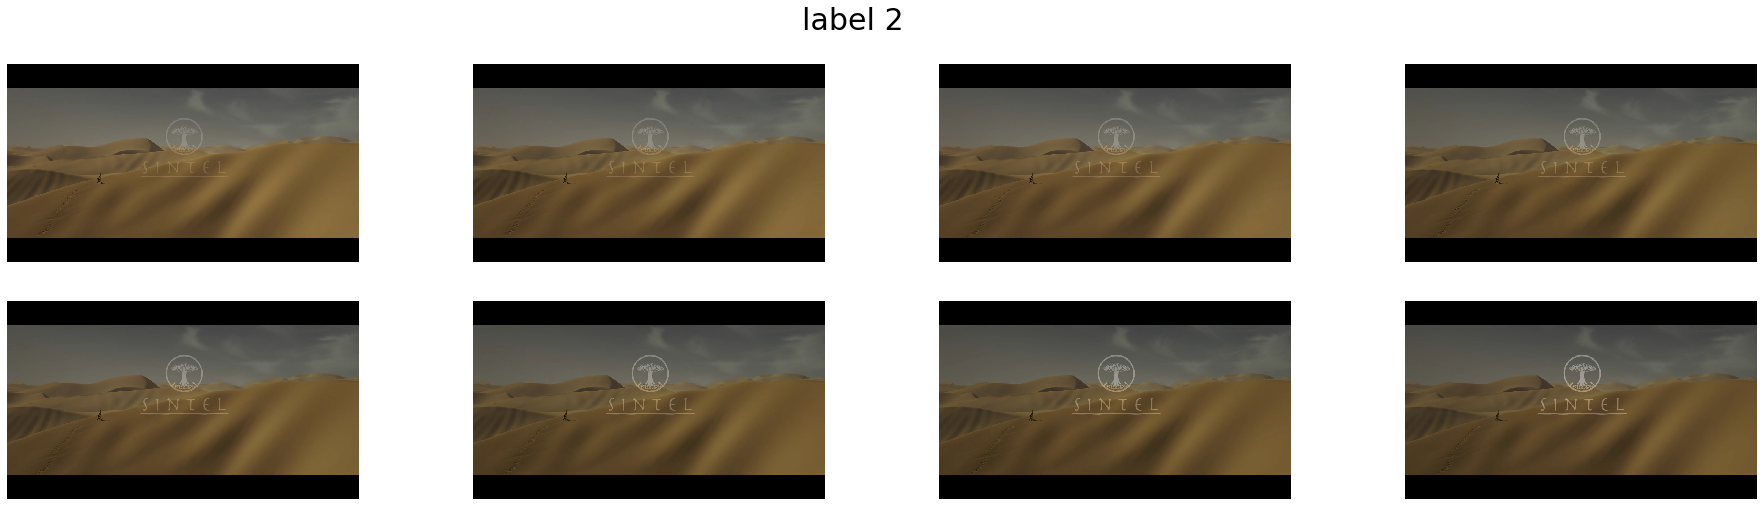

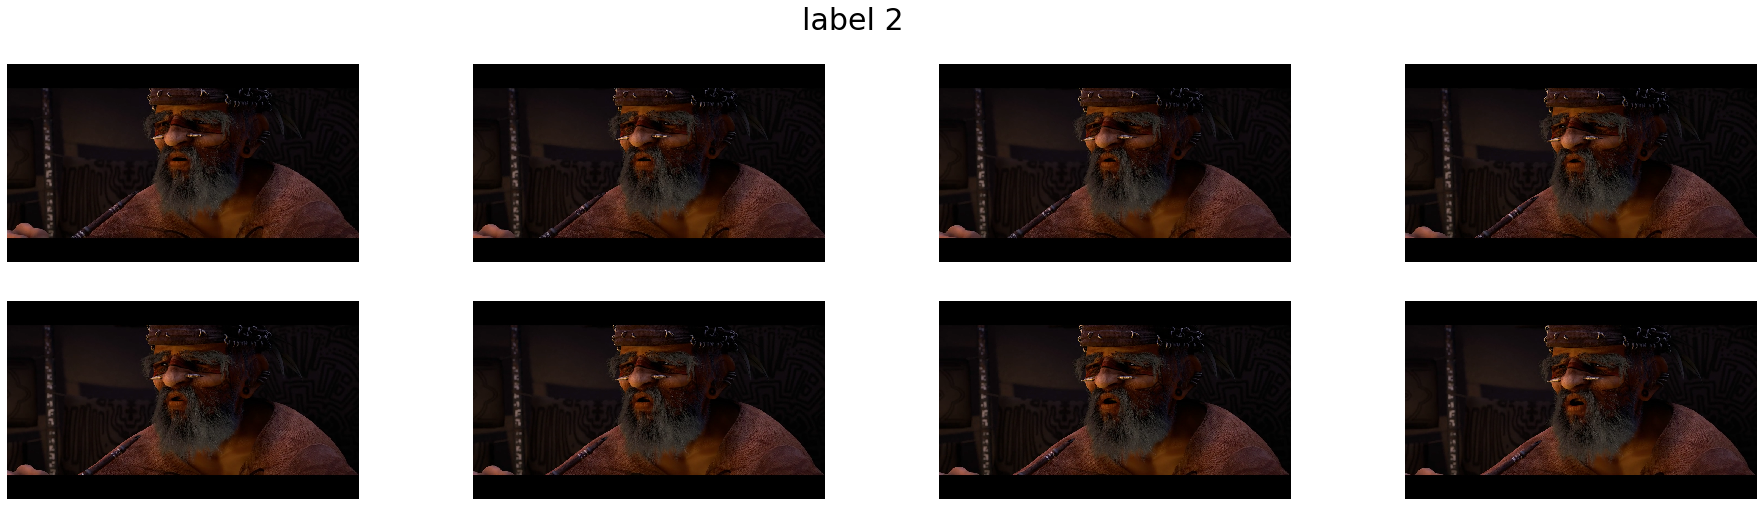

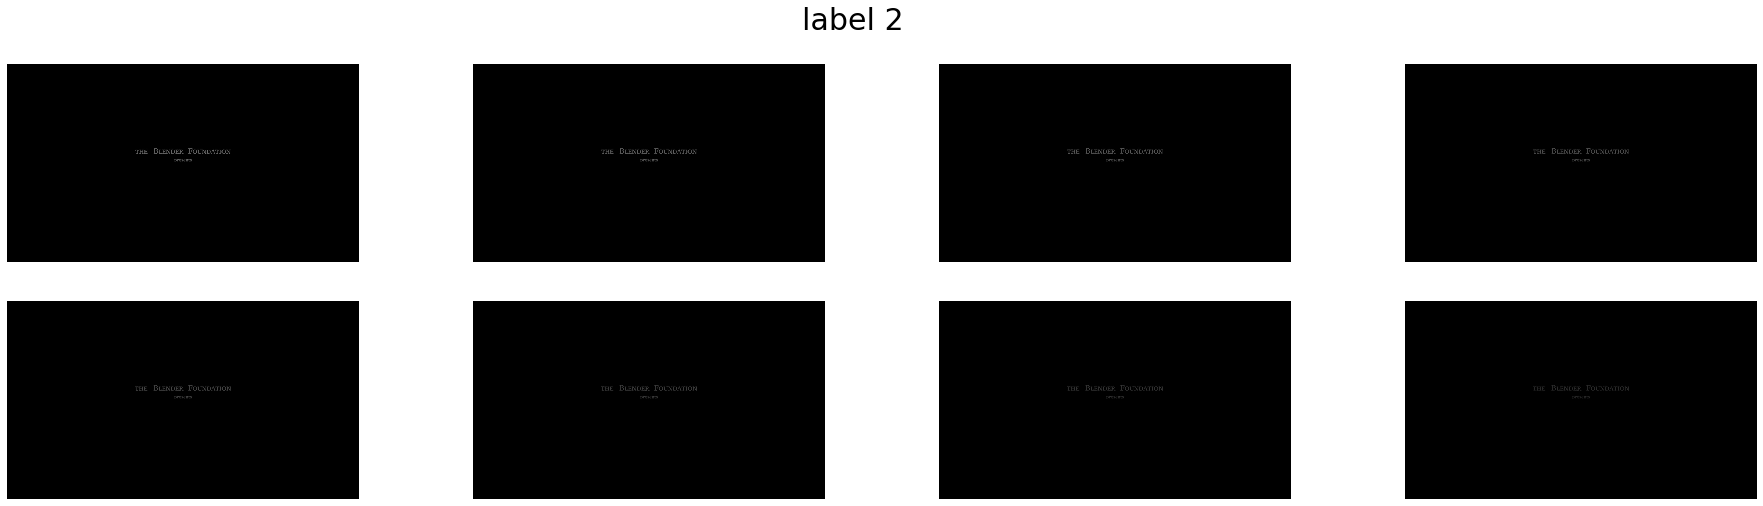

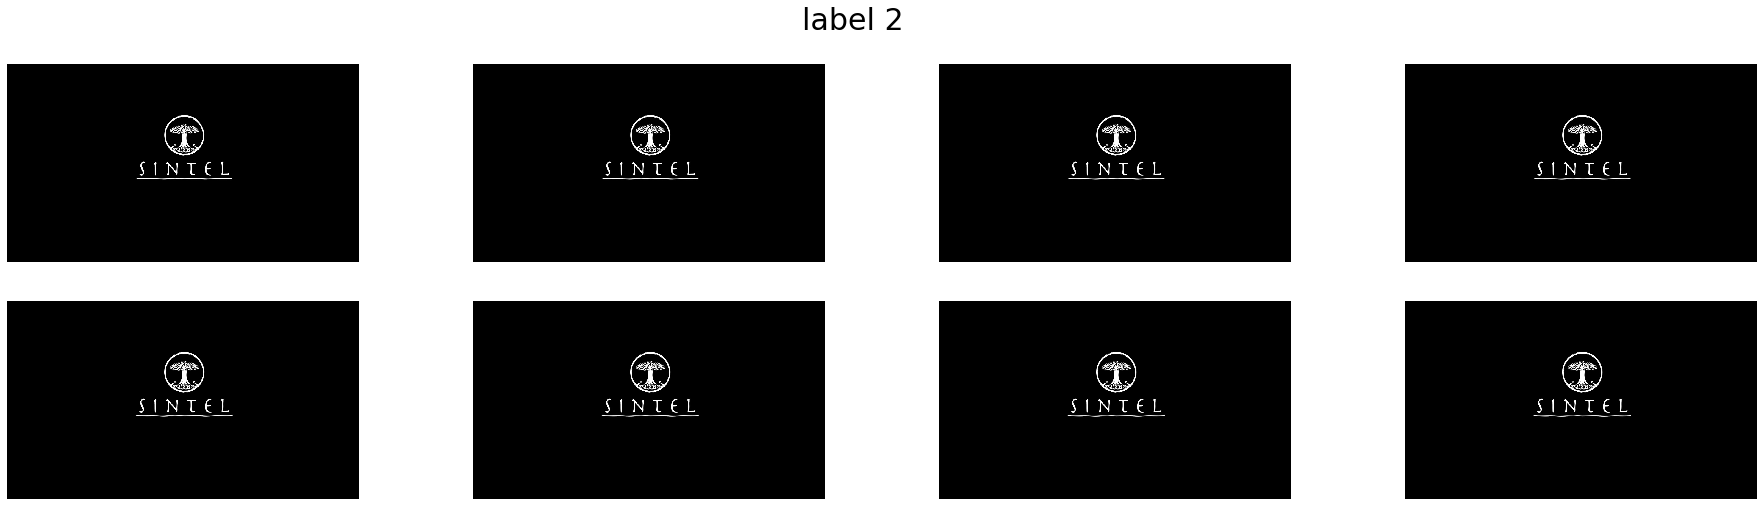

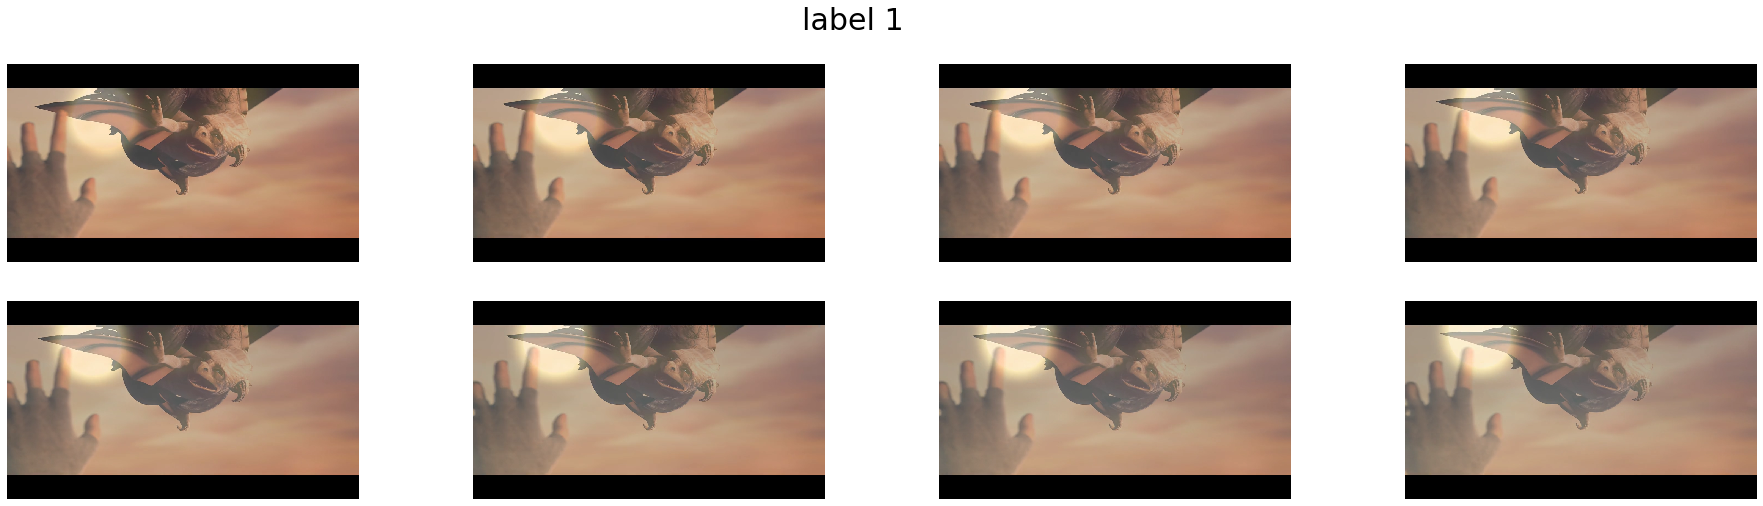

In [8]:
ITER = 5
for i in range(ITER):
    sequences_out, labels = pipe.run()
    sequences_out = sequences_out.as_cpu().as_array()
    labels = labels.as_cpu().as_array()
    show_sequence(sequences_out[1], labels[1])